# Phys 581 Winter 2019
# Assignment #1: Error Function
## Alexander Hickey, 10169582

In [2]:
#Import useful libraries
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import scipy
import scipy.special as special
import scipy.stats as stats
import scipy.integrate as integrate

import matplotlib.colors as colors

### Introduction

The error function is a special function that shows up frequently in the areas of probability, statistics, and partial differential equations that describe diffusion. It is defined as:

  $$\operatorname {erf} (x) :={\frac {1}{\sqrt {\pi }}}\int _{-x}^{x}e^{-t^{2}}\,dt ={\frac {2}{\sqrt {\pi }}}\int _{0}^{x}e^{-t^{2}}\,dt. $$ 


In statistics, for nonnegative values of x, the error function has the following interpretation: for a random variable Y that is normally distributed with mean 0 and variance 1/2, erf(x) describes the probability of Y falling in the range [−x, x]

There are several related functions which may be encountered in the physical sciences:

complementary error function
  $$erfc(z) = 1 - erf(z) $$
  
imaginary errror function
  $$erfi(z) = -i \, erf(iz) $$

Faddeeva function
  $$w(z) = e^{-z^2} erfc(-iz)$$
  
Dawson function  
  $$D(z) = \frac{\sqrt \pi}{2} e^{-z^2} erfi(z)$$ 
  
as well as Voight functions and Fresnel integrals.  

The error function is an entire function; it has no singularities (except that at infinity) and its Taylor expansion always converges.

The defining integral cannot be evaluated in closed form in terms of elementary functions, but by expanding the integrand $e^{−z^2}$ into its Maclaurin series and integrating term by term, one obtains the error function's Maclaurin series as:

$$ \operatorname {erf} (z)={\frac {2}{\sqrt {\pi }}}\sum _{n=0}^{\infty }{\frac {(-1)^{n}z^{2n+1}}{n!(2n+1)}}={\frac {2}{\sqrt {\pi }}}\left(z-{\frac {z^{3}}{3}}+{\frac {z^{5}}{10}}-{\frac {z^{7}}{42}}+{\frac {z^{9}}{216}}-\cdots \right) $$

which holds for every complex number z. 

The special.erf method is vectorized so that we can obtain multiple values for input sequences and grid

#### Task: Write a vectorized function using the Taylor series algorithm. 

In [2]:
def erf_taylor(z, nterms=19):
    '''
    
    '''
    #Cast to numpy array
    z = np.array(z)
    
    terms = np.zeros((nterms,)+z.shape, dtype=np.complex128)
    terms[0] = z
    z2 = -z*z  # move math outside loop
    for n in range(1,nterms):
        terms[n] = terms[n-1] * z2 / n * (2*n-1)/(2*n+1)
    
    return np.sum(terms, axis=0) * 2.0 / np.sqrt(np.pi)

#### Task: Compare results to special.erf and determine relative precision of the Taylor series algorithm for $|z| < 9$.

Include relative error, mask to |z|<9

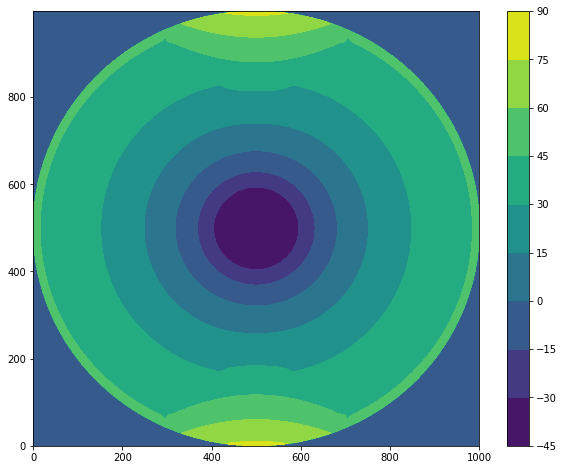

In [3]:
plt.figure(figsize = (10,8))

x,y = np.linspace(-9, +9, 1001),np.linspace(-9, +9, 999)
xx, yy = np.meshgrid(x,y)
gridxy = xx + 1.0j*yy
mask = (xx*xx+yy*yy < 9*9)*1


z1 = special.erf(gridxy)
z1 = z1 + (z1<=1e-16)*1e-16
z2 = erf_taylor(gridxy,nterms=23)
array = np.abs(z1-z2)
masked_array = array + (array<=1e-16)*1e-16
masked_array = np.log(masked_array)

plt.contourf(masked_array*mask)#,norm=colors.LogNorm(),cmap=cmap)
plt.colorbar()
plt.show()

#### Task: Write python code for some more complex algorithm that you find on the web ie.

Efficient Computation of the Complex Error Function
Walter Gautschi
SIAM Journal on Numerical Analysis
Vol. 7, No. 1 (Mar., 1970), pp. 187-198

Computation of the Complex Error Function
J. A. C. Weideman
SIAM Journal on Numerical Analysis
Vol. 31, No. 5 (Oct., 1994), pp. 1497-1518

More efficient computation of the complex error function.
G. P. M. Poppe and C. M. J. Wijers. 1990
ACM Trans. Math. Softw. 16, 1 (March 1990), 38-46. 
DOI: https://doi.org/10.1145/77626.77629

In [1]:
def w(z):
    #Works in first quadrant only
    x, y = np.real(z), np.imag(z)
    
    if y<4.29 and x<5.33:
        s=(1-y/4.29)*np.sqrt(1-x*x/28.41)
        h=1.6*s
        h2 = 2*h
        capn = int(6+23*s)
        nu = int(9+21*s)
        
    else:
        h, capn, nu = 0,0,8
        
    if h>0:
        lamb = h2**capn
    
    b = h==0 or lamb==0
    r1, r2, s1, s2 = 0,0,0,0
    for n in range(nu,-1,-1):
        np1 = n+1
        t1 = y+h+np1*r1
        t2 = x-np1*r2
        c= .5/(t1*t1+t2*t2)
        r1 = c*t1
        r2 = c*t2
        
        if h>0 and n<=capn:
            t1 = lamb + s1
            s1 = r1*t1-r2*s2
            s2 = r2*t1+r1*s2
            lamb = lamb/h2
    
    if y==0:
        re = np.exp(-x*x)
    else:
        re = 1.12837916709551*(r1*b+s1*(not b))
    
    im = 1.12837916709551*(r2*b+s2*(not b))
    
    return re+im*1.0j

In [5]:
def w_vec(z):
    
    #Map to numpy array
    z = np.array(z)
    
    #Works in first quadrant only
    x, y = np.real(z), np.imag(z)
    
    inner = (y<4.29 and x<5.33)*1
    outer = np.logical_not(inner)
    
    s= (1-y/4.29)*np.sqrt(1-x*x/28.41)*inner+0*outer
    h= (1.6*s)*inner + 0*outer
    h2 = 2*h
    capn = int((6+23*s)*inner+0*outer)
    nu = int((9+21*s)*inner +8*outer)
    
    lamb = (h2**capn)*((h>0)*1)
    
    b = (h==0 or lamb==0)
    
    r1 = np.zeros(z.shape)
    r2, s1, s2 = r1.copy(), r1.copy(), r1.copy()
    
    for n in range(np.max(nu),-1,-1):
        
        #Loop updates t1,t2,c,r1,r2
        mask = (nu>0)*1 #Only act on 
        np1 = n+1
        t1 = y+h+np1*r1
        t2 = x-np1*r2
        c= .5/(t1*t1+t2*t2)
        r1 = c*t1
        r2 = c*t2
        
        if h>0 and n<=capn:
            t1 = lamb + s1
            s1 = r1*t1-r2*s2
            s2 = r2*t1+r1*s2
            lamb = lamb/h2
    
    if y==0:
        re = np.exp(-x*x)
    else:
        re = 1.12837916709551*(r1*b+s1*(not b))
    
    im = 1.12837916709551*(r2*b+s2*(not b))
    
    return re+im*1.0j

#### Task: Develop a testing framework for your error function

In [19]:
import unittest

class TestSum(unittest.TestCase):
    '''
    Class Doc String
    '''
    def test_sum(self):
        '''
        Doc String
        '''
        self.assertEqual(6, 6)

    def test_sum2(self):

        self.assertEqual(sum([1,1]),2)
        
unittest.main(argv=[''],verbosity=2,exit=False)

test (__main__.MyTest) ... ok
test_sum (__main__.TestSum) ... ok
test_sum2 (__main__.TestSum) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.010s

OK


In [20]:
test = TestSum()
help(TestSum)

Help on class TestSum in module __main__:

class TestSum(unittest.case.TestCase)
 |  Class Doc String
 |  
 |  Method resolution order:
 |      TestSum
 |      unittest.case.TestCase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  test_sum(self)
 |      Doc String
 |  
 |  test_sum2(self)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from unittest.case.TestCase:
 |  
 |  __call__(self, *args, **kwds)
 |      Call self as a function.
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  __hash__(self)
 |      Return hash(self).
 |  
 |  __init__(self, methodName='runTest')
 |      Create an instance of the class that will use the named test
 |      method when executed. Raises a ValueError if the instance does
 |      not have a method with the specified name.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  __str__(self)
 |      Return str(self).
 |  
 |  addCleanup(self, function, *args, **k

### Conclusion